# Подготовка данных

Функция data_loader загружает батчи нужного размера для трейна и теста. Можно регулировать размер батча, трансформы, если они нам понадобятся, и долю тестовой выборки в датасете. Пример использования этой функции в разделе Test. Подключаемый файл data_preparation.py

Подключение файла:
- import data_preparation

Теперь по данным, нужно загрузить датасет LISA в ту же папку, что и ноутбуки все. Скачивается архив, распаковываешь его в папку с названием LISA, которая находится там же, где и ноутбуки.
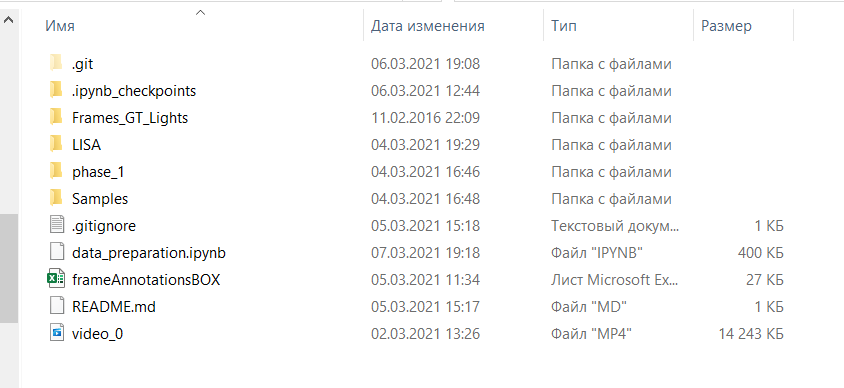

В папке LISA должны лежать вот эти файлы
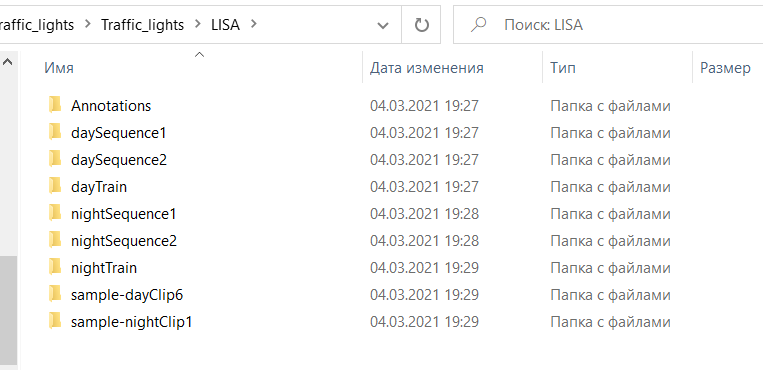

Больше ничего с файлами делать не требуется

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import pandas as pd
from torchvision import transforms
import torchvision
import json

In [19]:
# cap = cv.VideoCapture("phase_1/video_0.MP4") # Вывод с видео файла
# length = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
# width  = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
# height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
# print(length)
# print("width",width)
# print("height",height)

1203
width 1280
height 720


In [2]:
print(torch.__version__)

1.8.0+cu111


## Создание генератора датасета

### Создание класса датасета

In [3]:
class LISADataset(object):
    def __init__(self):
        # загрузка датасета аннотаций для bounding box'ов
        for i in range(1,14):
            folder = "dayClip"+str(i)
            annotations_path = "LISA/Annotations/Annotations/dayTrain/"+folder+"/frameAnnotationsBOX.csv"
            df_i = pd.read_csv(annotations_path, sep = ';')
    
            images_path = "LISA/dayTrain/dayTrain/"+folder+"/frames"
            imgs_temp = list(sorted(os.listdir(images_path)))
            imgs_i = [imgs_temp[i] for i in df_i["Origin frame number"].unique()]
    
            if i==1:
                self.df = df_i.copy()
                self.imgs = imgs_i
            else:
                self.df = pd.concat([self.df, df_i], ignore_index = True)
                self.imgs = self.imgs + imgs_i

    def __getitem__(self, idx):
        # load images
        print(idx)
        img_folder = self.imgs[idx][:9]
        if img_folder[-1]=='-':
            img_folder = img_folder[:-1]
        print(self.imgs[idx])
            
        img_path = os.path.join("LISA\dayTrain\dayTrain", img_folder, "frames", self.imgs[idx])
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)/255

        # get bounding box coordinates for each mask
        num_objs = len(self.df[self.df["Filename"]=="dayTraining/"+self.imgs[idx]])
        boxes = []
        for i in range(num_objs):
            x_left = list(self.df[self.df["Filename"]=="dayTraining/"+self.imgs[idx]]["Upper left corner X"])[i]
            x_right = list(self.df[self.df["Filename"]=="dayTraining/"+self.imgs[idx]]["Lower right corner X"])[i]
            y_left = list(self.df[self.df["Filename"]=="dayTraining/"+self.imgs[idx]]["Upper left corner Y"])[i]
            y_right = list(self.df[self.df["Filename"]=="dayTraining/"+self.imgs[idx]]["Lower right corner Y"])[i]
            boxes.append([x_left, y_left, x_right, y_right])
        print(boxes)

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        
        img = torch.tensor(img, dtype=torch.float32)
        return img, target

    def __len__(self):
        return len(self.imgs)

In [4]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [5]:
def data_loader(batch_size, transform = None, test_size = 0.2):
    
    dataset_train = LISADataset()
    dataset_test = LISADataset()
    indices = torch.randperm(len(dataset_train)).tolist()
    
    t = round(len(dataset_train)*test_size)
    dataset_train = torch.utils.data.Subset(dataset_train, indices[:-t])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-t:])
    
    data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
    data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
    
    return data_loader_train, data_loader_test
    

# Предсказание для видео

In [16]:
def video_predict(path, model):
    cap = cv.VideoCapture(path) # Вывод с видео файла
    dict_predictions = {}
    model.eval()
    i=0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        with torch.no_grad():
            frame = torch.tensor(frame, dtype=torch.float32)
            frame = [torch.reshape(frame, (3, frame.shape[0], frame.shape[1])).to(device)]
            prediction = model(frame)
            dict_predictions[i]=[]
            for j, box in enumerate(prediction[0]['boxes']):
                dict_predictions[i].append({j:list(map(str,box.cpu().numpy().astype(np.int32)))})
                #тут прикрутить определение цвета светофора
                #определить влияние на полосу
        i+=1
    json_file_name = 'test_pred_'+path[8:15]+'.txt'
    with open(json_file_name, 'w') as outfile:
        json.dump(dict_predictions, outfile)

# Создание видео с box'ами

In [46]:
#без сглаживания
def display_video(source_video_path, target_video, vid_boxes):
    cap = cv.VideoCapture(source_video_path)
    width  = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
    i=0
    out = cv.VideoWriter(target_video,cv.VideoWriter_fourcc(*'DIVX'), 30, (width, height))
    with open(vid_boxes) as json_file:
        data = json.load(json_file)
        
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        boxes = []
        for box in data[str(i)]:
            value = list(box.values())[0]
            boxes.append(list(map(int, value)))
            
        for box in boxes:
            cv.rectangle(frame, (box[2], box[3]), (box[0], box[1]), (220, 0, 0), 3)

        out.write(frame)
        i += 1
        
    out.release()

# Test

Тут я тестирую созданные функции, можно не обращать внимание

In [6]:
torch.cuda.empty_cache()

In [10]:
device = torch.device('cuda:0')

In [11]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = LISADataset()
train, test = data_loader(batch_size = 2)
# For Training
images,targets = next(iter(train))
images = list(torch.reshape(image, (3, image.shape[0], image.shape[1])).to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
model.to(device)
model.train()

9670
dayClip7--02684.jpg
[[62, 343, 113, 408]]
1325
dayClip1--01328.jpg
[[838, 180, 871, 238], [987, 215, 1014, 260], [1158, 295, 1185, 335]]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Предсказания для видео

In [17]:
%%time
video_predict("phase_1/video_0.MP4", model) #пример использования

Wall time: 8min 13s


In [42]:
def display_video(source_video_path, target_video, vid_boxes):
    cap = cv.VideoCapture(source_video_path)
    width  = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
    i=0
    out = cv.VideoWriter(target_video,cv.VideoWriter_fourcc(*'DIVX'), 30, (width, height))
    with open(vid_boxes) as json_file:
        data = json.load(json_file)
        
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        boxes = []
        for box in data[str(i)]:
            value = list(box.values())[0]
            boxes.append(list(map(int, value)))
            
        for box in boxes:
            cv.rectangle(frame, (box[2], box[3]), (box[0], box[1]), (220, 0, 0), 3)

        out.write(frame)
        i += 1
        
    out.release()

In [44]:
display_video("phase_1/video_0.MP4", 'video_0_boxes.avi', 'test_pred_video_0.txt')

### запись реальных box'ов в файл для теста воспроизведения

In [45]:
length = 2161

df = pd.read_csv("LISA/Annotations/Annotations/dayTrain/dayClip1/frameAnnotationsBOX.csv", sep = ';')
images_path = "LISA/dayTrain/dayTrain/dayClip1/frames"
imgs = list(sorted(os.listdir(images_path)))
out = cv.VideoWriter('train_video_boxes.avi',cv.VideoWriter_fourcc(*'DIVX'), 24, (1280, 960))

for i in range(length):
    
    num_objs = len(df[df["Origin frame number"]==i])
    img = cv.imread("LISA/dayTrain/dayTrain/dayClip1/frames/"+imgs[i])
    if num_objs == 0:
        out.write(img)
        continue
    
    x_left = list(df[df["Origin frame number"]==i]["Upper left corner X"])
    x_right = list(df[df["Origin frame number"]==i]["Lower right corner X"])
    y_left = list(df[df["Origin frame number"]==i]["Upper left corner Y"])
    y_right = list(df[df["Origin frame number"]==i]["Lower right corner Y"])
    
    for j in range(num_objs):
        cv.rectangle(img, (x_right[j], y_right[j]), (x_left[j], y_left[j]), (220, 0, 0), 3)
        
    out.write(img)
    
out.release()

In [37]:
images_path = "LISA/dayTrain/dayTrain/dayClip1/frames"
imgs = list(sorted(os.listdir(images_path)))
out = cv.VideoWriter('train_video_0.avi',cv.VideoWriter_fourcc(*'DIVX'), 24, (1280, 960))
for i in range(length):
    img = cv.imread("LISA/dayTrain/dayTrain/dayClip1/frames/"+imgs[i])
    out.write(img)
out.release()

length = 2161

df = pd.read_csv("LISA/Annotations/Annotations/dayTrain/dayClip1/frameAnnotationsBOX.csv", sep = ';')
dict_box = {}

for i in range(length):
    dict_box[i]=[]
    num_objs = len(df[df["Origin frame number"]==i])
    
    x_left = list(df[df["Origin frame number"]==i]["Upper left corner X"])
    x_right = list(df[df["Origin frame number"]==i]["Lower right corner X"])
    y_left = list(df[df["Origin frame number"]==i]["Upper left corner Y"])
    y_right = list(df[df["Origin frame number"]==i]["Lower right corner Y"])
    
    for j in range(num_objs):
        dict_box[i].append({j:[str(x_left[j]), str(y_left[j]), str(x_right[j]), str(y_right[j])]})
json_file_name = 'train_true_boxes.txt'
with open(json_file_name, 'w') as outfile:
    json.dump(dict_box, outfile)

In [43]:
display_video("train_video_0.avi", "func_train_video_boxes.avi", "train_true_boxes.txt")

# Черновики

In [ ]:
# For inference
model.eval()
i = 0
with torch.no_grad():
    images,targets = next(iter(test))
    images = list(torch.reshape(image, (3, image.shape[0], image.shape[1])).to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    predictions = model(images)           # Returns predictions

сначала полностью заполняю словарь для ВСЕХ кадров видео, а потом уже записываю его в файл

In [82]:
print(predictions)

[{'boxes': tensor([[ 375.1907,  560.0817,  412.9113,  608.1020],
        [   0.0000,   18.2444, 1280.0000,  914.4471],
        [ 429.9521,  451.0756,  488.2532,  530.8286],
        [ 355.5041,  555.9023,  412.7646,  622.3280],
        [ 493.3779,  458.2231,  538.8397,  598.7299],
        [ 438.2015,  454.9249,  468.8076,  523.9169]], device='cuda:0'), 'labels': tensor([10,  7, 10, 10, 10, 10], device='cuda:0'), 'scores': tensor([0.8850, 0.4269, 0.0935, 0.0593, 0.0578, 0.0542], device='cuda:0')}, {'boxes': tensor([[  35.8657,   15.0157, 1280.0000,  911.1941],
        [ 279.8253,   76.4660, 1012.9071,  833.5303]], device='cuda:0'), 'labels': tensor([7, 7], device='cuda:0'), 'scores': tensor([0.8010, 0.0624], device='cuda:0')}]


In [41]:
dict_predictions = {}
dict_predictions[0]=[]
for j, box in enumerate(predictions[0]['boxes']):
    dict_predictions[0].append({j:list(map(str,box.cpu().numpy().astype(np.int32)))})
    # тут добавить определение цвета и влияния светофора позже

with open('test_pred.txt', 'w') as outfile:
    json.dump(dict_predictions, outfile)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


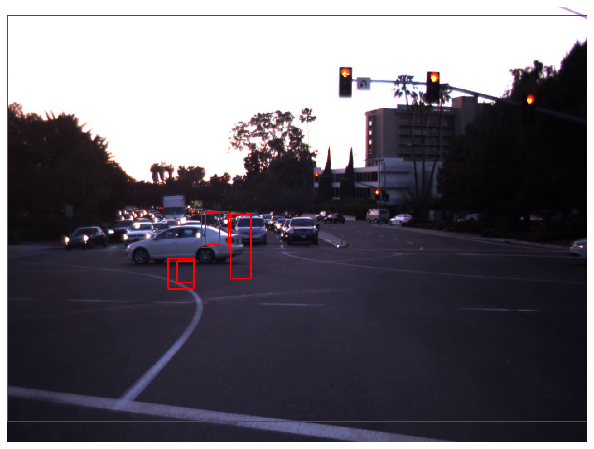

In [77]:
with open('test_pred.txt') as json_file:
    data = json.load(json_file)
    #для одного кадра
    boxes = []
    for box in data[str(0)]:
        value = list(box.values())[0]
        boxes.append(list(map(int, value)))
    displayImage(images[0].cpu().numpy(), boxes, False)

In [78]:
image = images[0].cpu().numpy()

In [79]:
def displayImage(image, boxes, to_cpu):
    if to_cpu:
        boxes = boxes.cpu().numpy().astype(np.int32)
    image_temp = np.reshape(image, (image.shape[1],image.shape[2], image.shape[0]))
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv.rectangle(image_temp,
                      (box[2], box[3]),
                      (box[0], box[1]),
                      (220, 0, 0), 2)

    ax.set_axis_off()
    ax.imshow(image_temp)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


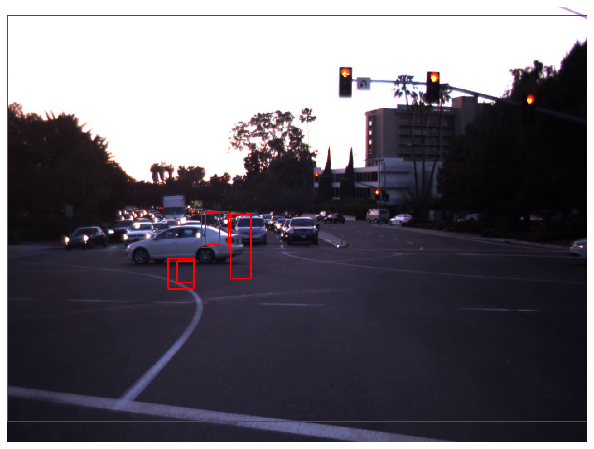

In [81]:
displayImage(image, predictions[0]['boxes'], True)

# Препроцессинг видео

In [ ]:
ret, frame = cap.read()

In [8]:
frame.shape

(720, 1280, 3)

In [5]:
cv.imshow("frame", frame)
cv.waitKey()
cv.destroyAllWindows()